In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
%matplotlib inline

In [2]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [3]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [ ]:
params =['default','taulnir', 'dleaf', 'tkd_sand', 'bsw_sf', 'n_melt_coef', 'medlynslope', 
         'jmaxb1', 'kmax', 'dbh', 'grperc', 'FUN_fracfixers', 
         'froot_leaf', 'leaf_long', 'tau_cwd', 'k_nitr_max_perday', 'cli_scale', 'vcmaxha']
p2 = []
for p in params:
    if (p=='dleaf'):
        p2.append('dleaf-hi')
    elif (p=='default'):
        p2.append(p)
    else:
        p2.append(p+'-lo')
        p2.append(p+'-hi')

In [7]:
members = ['OAAT'+str(i).zfill(4) for i in range(35)]
members.remove('OAAT0003')

In [9]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/hist/'
thefiles = [glob.glob(thedir+'*'+member+'*.h1.*')[0] for member in members]

In [11]:
ds = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')
nmonths = len(ds.time)
yr0 = ds['time.year'][0].values
ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
ds['keys']=xr.DataArray(members,dims='ens')
ds['pft']=ds['pfts1d_itype_veg'].sel(ens=0) #reassign pft variable for easier analysis

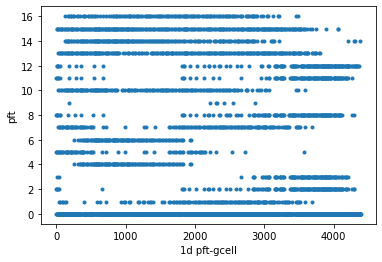

In [64]:
plt.plot(ds.pft,'.')
plt.xlabel('1d pft-gcell')
plt.ylabel('pft');

In [76]:
npixels = (ds['TLAI'].sel(ens=0).max(axis=0)>0.1).groupby('pft').sum()[1:]
ee = 1
pfts = 1+np.arange(16)
nens = len(ds.ens)
survival = np.zeros([16,nens])
for i,ee in zip(range(nens),ds.ens.values):
    survival[:,i] = 100*((ds['TLAI'].sel(ens=ee).max(axis=0)>0.1).groupby('pft').sum()[1:])/npixels


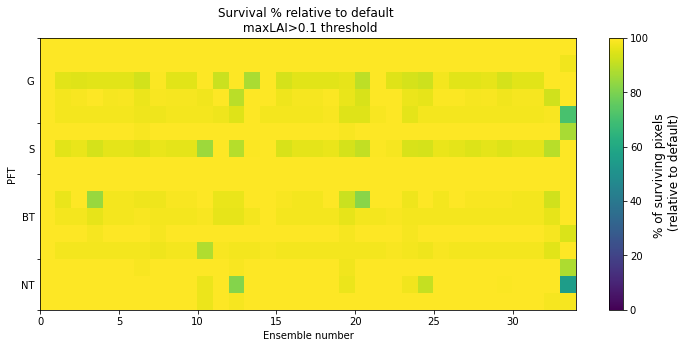

In [92]:
fig,ax = plt.subplots(figsize=[12,5])
plt.pcolormesh(survival,vmax=100,vmin=0)
cbar =plt.colorbar()
plt.title('Survival % relative to default \n maxLAI>0.1 threshold')
plt.yticks([0,3,8,11,16])
ax.set_yticks([1.5,5.5,9.5,13.5], minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.ylabel('PFT')
plt.xlabel('Ensemble number');
cbar.set_label('% of surviving pixels \n (relative to default)',fontsize=12)

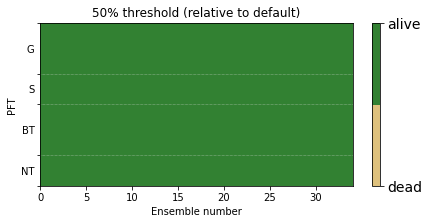

In [107]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([50,130,50])/256
newcmp = matplotlib.colors.ListedColormap(vals)

thresh = 50
alive = survival>thresh
fig,ax = plt.subplots(figsize=[7,3])
plt.pcolormesh(alive,cmap=newcmp,vmin=0,vmax=1)

cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=14) 
plt.yticks([0,3,8,11,16])
ax.set_yticks([1.5,5.5,9.5,13.5], minor=True)
for y in [3,8,11]:
    plt.plot([0,nens],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.title('50% threshold (relative to default)')
plt.ylabel('PFT')
plt.xlabel('Ensemble number');